# Numerical Optimization With Python

*Contributors: Dr Yae GABA; Dr Aurelle TCHAGNA; Mr. Domini LEKO*

## Pre-Course 4: Roots of Equations


## Learning objectives:


* Identify nonlinear equations


* Solve these equations using the `scipy.optimize` functions `bisect` and `newton` 


* Explain the algorithms that underlie the Bisection, Newton and Secant method


* Explain why these methods are considered *iterative* and *approximative* and how this relates to *tolerances*


* Demonstrate several types of *convergence* errors

In [1]:
# some imports we will make at the start of every notebook
# later notebooks may add to this with specific SciPy modules

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# scipy's optimization
import scipy.optimize as sop

# Nonlinear Equations

A **system is said to be linear** if it can be represented by a **linear function** (*i.e.* a straight line in 1D):


$$ f(x) := a + kx, $$


where $k$ and $a$ are constants.

$f(x)$ can be thought of as a quantity of interest that depends on some variable $x$, which can be quantified through measurements or observations - see L1.

<br>
[NB. Technically this is actually what's called an ***affine function***, it's strictly speaking only linear if $a=0$ - <https://math.stackexchange.com/questions/275310/what-is-the-difference-between-linear-and-affine-function> - in some situations the difference between linear and affine is important, but here it isn't.]
<br>

To a linear function we can associate a **linear equation**, which can be written in the form:


$$ f(x) = 0 \;\;\;\; \text{where} \;\;\;\; f(x) := a + kx. $$


We've set the *function* equal to something (here we chose zero) to obtain an *equation*.

<br>

[Our aim will be to find a solution $x$ to this equation. Note that for linear problems this is trivial if the problem is scalar valued (in which case $x = -a/k$), in the following lectures we will consider linear systems for vectors - i.e. matrix systems. Here we consider how to deal with the complexities that arise when the problem is **not** linear (but for simplicity still scalar valued).]

## Examples of nonlinearity

Note that the majority of real world systems cannot be expressed in such simple (linear) terms. 

[Note also that discretisations of nonlinear ODEs or PDEs (e.g. being nonlinear in order to accurately represent the nonlinear real world) results in nonlinear discrete systems for which we need to make use of techniques such as those introduced in this lecture.]

They are then called nonlinear systems, and equations representing them contain terms like:


-  $ x^2,\; x^3,\ldots\;\;\;$ e.g. higher ($>1$) order powers that would appear in polynomials.


- $ \sqrt{x},\; x^{1/3}, x^{\pi},\ldots \;\;\; $ e.g. roots, radicals and other non-integer polynomials.


- $\tan(x),\; \sin(x), \; \log(x),\; \text{erf}(x), \ldots \;\;\; $ e.g. trigonometric and other [*special functions*](https://en.wikipedia.org/wiki/Special_functions).

<br>

You should be familiar, for example, with quadratic equations $f(x) := a x^2 + bx + c = 0$, for which there exist the well known analytic solutions:

$$
x^*_{1,2} := \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}\,.
$$

The solutions $\,x^*_{1,2}\,$ are commonly referred to as the **roots** of the equation - this means that $\,f(x^*_{1}) = f(x^*_{2}) =0$.

Note that depending on the coefficients this nonlinear problem can have 2, 1, or no real-valued solutions!

When we say *analytic (or analytical) solution*, we just mean that we can write down the solution as something that we can readily evaluate - as per the solutions we obtain in the 2nd year module on PDEs. For a discussion see <https://en.wikipedia.org/wiki/Closed-form_expression>.

## An example nonlinear equation

An example of a nonlinear problem without trivial solution is:

$$ x = \tan(x). $$

There is no exact analytic solution to this equation, so we have to devise methods to find approximate solutions of this equation.

That is, we are looking for  $x_{\text{approx}}$ such that 

$$x _{\text{approx}} \approx \tan(x_{\text{approx}}), $$ 

to a set *tolerance* (or *precision*). 

<br>

Note that we can of course equivalently look to solve the problem 

$$ f(x) \approx 0 \;\;\;\;\text{where}\;\;\;\; f(x):= x - \tan(x), $$  

[or of course equivalently we could instead choose to define $\,f(x):= \tan(x) - x$].

We will often do this (move all terms of our equation to one side and set equal to zero) to make our presentation of the theory below, as well as our implementation of solvers, generic. In this context a solution to the problem $f(x)=0$ is called a **root**.

<br>

Q. Why is this equation nonlinear ? How many roots does this equation have ?


We will see a plot of this problem in a couple of cells.

# Picard's method of successive approximations (or fixed point iteration)


## Fixed points

Before moving on to problems written in the completely general form $\,f(x) = 0$, in this section we will consider equations that can be written as:


$$ x = g(x), $$


where $g$ is a given function.

<br>

[Of course if we're given a problem of the second type we can make it look like the first simply by defining $\,f(x) := x-g(x)\,$ or $\,f(x) = g(x)-x,\,$ as we did for the problem involving $\,\tan\,$ above]

<br>

An $x$ that satisfies this equation is sometimes called a **fixed point** of the function $g$.

It's called this since if we keep applying the function $g$ to the output, then the output never changes, i.e.


$$x = g(x) = g(g(x)) = g(g(g(x))) = \ldots $$

<br>

As an example, consider the function


$$ g(x) := x^{2}-3x+4. $$


This has the fixed point 2, since $g(2)=2$.

While the example


$$ g(x) = x+1, $$


clearly has no fixed points - every application of the function adds another one to our $x$.

<br>

**Identifying fixed points visually**

If we plot the function $y = g(x)$ as a curve in $(x,y)$ space then the fixed points (if they exist) are the locations where this curve intersects with the line $y=x$.

Let's see some examples.

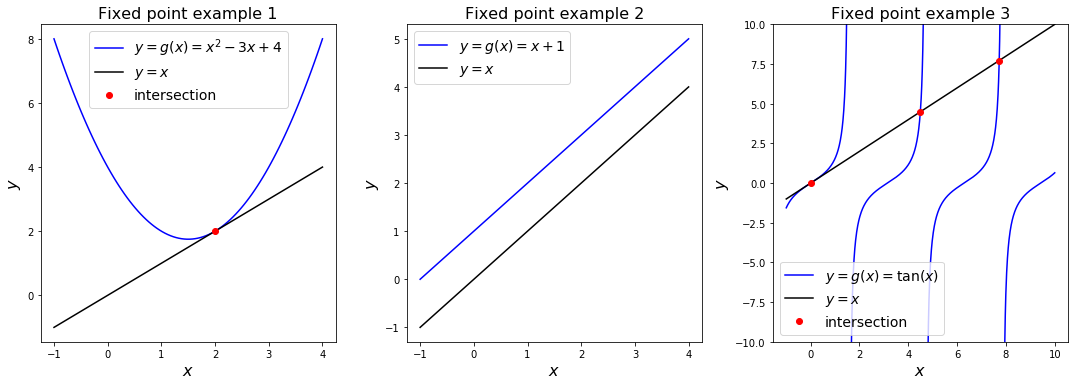

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(w_pad=4)

x = np.linspace(-1,4,100)
ax1.plot(x, x**2 - 3*x + 4, 'b', label='$y = g(x) = x^2-3x+4$')
ax1.plot(x, x, 'k', label='$y = x$')
ax1.plot(2, 2, 'ro', label='intersection')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Fixed point example 1', fontsize=16)
ax1.legend(loc='best', fontsize=14)

x = np.linspace(-1,4,100)
ax2.plot(x, x+1, 'b', label='$y = g(x)=x+1$')
ax2.plot(x, x, 'k', label='$y = x$')
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('Fixed point example 2', fontsize=16)
ax2.legend(loc='best', fontsize=14)

x = np.linspace(-1,10,1000)
y = np.tan(x)
# don't plot large values - comment out next two lines to see issue
y[y>100.] = np.inf
y[y<-100.] = -np.inf
ax3.plot(x, y, 'b', label=r'$y = g(x)=\tan(x)$')
ax3.plot(x, x, 'k', label='$y = x$')
# I know that tan(0) = 0, so I already know one of the roots 
ax3.plot(0, 0, 'ro', label='intersection')
# NB. the following values found below using bisection
ax3.plot(4.493409156799316, 4.493409156799316, 'ro')
ax3.plot(7.725251197814941, 7.725251197814941, 'ro')
ax3.set_ylim([-10,10])
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('Fixed point example 3', fontsize=16)
ax3.legend(loc='best', fontsize=14)

### Observations

The first example has a single unique fixed point, the second has no fixed point, and the third has infinitely many.

## Algorithm (Picard iteration)

Perhaps the simplest method to find approximate fixed points/roots to this kind of equation consists in guessing $x$, plugging it into the right-hand-side $g(\cdot)$ and evaluating the function. 

The resulting new value for $x$ is then used as an updated guess. 

A sequence of $x^{(k)}$ values are thus defined via the iteration:

$$ x^{(k+1)} = g\left(x^{(k)}\right), $$

starting from some initial guess $x^{(0)}$.

This procedure can be repeated until some stopping criteria is met, e.g. when two consecutive values for $x$ differ by less than some user-defined tolerance.   

Note that here 

$$x^{(k+1)} - x^{(k)} = g\left(x^{(k)}\right) - x^{(k)}$$ 

and so the 'change in $x$' value dropping below our tolerance is equivalent to us satisfying $x=g(x)$ to that same tolerance!

This strategy is often referred to as (Picard's) method of successive approximations. 

A pseudo-code description of this solution strategy looks like

```
guess x
x_previous := x + 2*tolerance   # so that the initial evaluation in the while loop is true.
while ( abs(x - x_previous) > tolerance ) do   
    x_previous := x
    x := g(x_previous)
```

## <span style="color:blue">Exercise 4.1: </span>

Complete the implementation of the method of successive approximations below to solve 

$$x=\mathrm{e}^{-x}$$

In [ ]:
def picard(f, x, atol=1.0e-6):
    """ Function implementing Picard's method.
    
    f here is the function g(.) described in the lecture and we are solving x = g(x).
    
    x is an initial guess.
    
    atol is a user-defined (absolute) error tolerance.
    """
    # record number of function evaluations so we can later compare methods
    fevals = 0
    # initialise the previous x simply so that while loop argument is initially true
    x_prev = x + 2*atol
    while abs(x - x_prev) > atol:
        x_prev = x
        
        
        ## ONE LINE OF MISSING CODE
        
        
        fevals += 1
        print('Current iteration solution: ',x, x_prev)
    print('\nPicard used', fevals, 'function evaluations')
    return x



def g(x):
    return np.exp(-x)


print('\nSolution from Picard: ', picard(g, 0.9, atol=1.0e-7))  # 0.9 is our initial guess


# let's check our answer against a SciPy function: sop.newton.
def f(x):
    return x - np.exp(-x)

print('\nCheck this against the solution from SciPy: sop.newton(f, 0.9)=', sop.newton(f, 0.9))

# NB. if we tighten up the atol toelrance in our call to picard the answer gets closer to SciPy 
# but of course takes more iterations.

To get a better idea of what is going on here let's look at the progression of the intermediate results $\,x^{(k+1)}\,$ from $\,x^{(k+1)} = g\left(x^{(k)}\right)\,$, and plot them on top of the curve $y = \mathrm{e}^{-x}$.

NB. I include the plotting code here for completeness, but you can ignore the details if you're not interested.

x_00 = 1.00000.   g(x_00) = 0.36788.   |x_00 - g(x_00)| = 0.63212
x_01 = 0.36788.   g(x_01) = 0.69220.   |x_01 - g(x_01)| = 0.32432
x_02 = 0.69220.   g(x_02) = 0.50047.   |x_02 - g(x_02)| = 0.19173
x_03 = 0.50047.   g(x_03) = 0.60624.   |x_03 - g(x_03)| = 0.10577
x_04 = 0.60624.   g(x_04) = 0.54540.   |x_04 - g(x_04)| = 0.06085
x_05 = 0.54540.   g(x_05) = 0.57961.   |x_05 - g(x_05)| = 0.03422
x_06 = 0.57961.   g(x_06) = 0.56012.   |x_06 - g(x_06)| = 0.01950
x_07 = 0.56012.   g(x_07) = 0.57114.   |x_07 - g(x_07)| = 0.01103
x_08 = 0.57114.   g(x_08) = 0.56488.   |x_08 - g(x_08)| = 0.00626
x_09 = 0.56488.   g(x_09) = 0.56843.   |x_09 - g(x_09)| = 0.00355
x_10 = 0.56843.   g(x_10) = 0.56641.   |x_10 - g(x_10)| = 0.00201
x_11 = 0.56641.   g(x_11) = 0.56756.   |x_11 - g(x_11)| = 0.00114
x_12 = 0.56756.   g(x_12) = 0.56691.   |x_12 - g(x_12)| = 0.00065
x_13 = 0.56691.   g(x_13) = 0.56728.   |x_13 - g(x_13)| = 0.00037
x_14 = 0.56728.   g(x_14) = 0.56707.   |x_14 - g(x_14)| = 0.00021
x_15 = 0.5

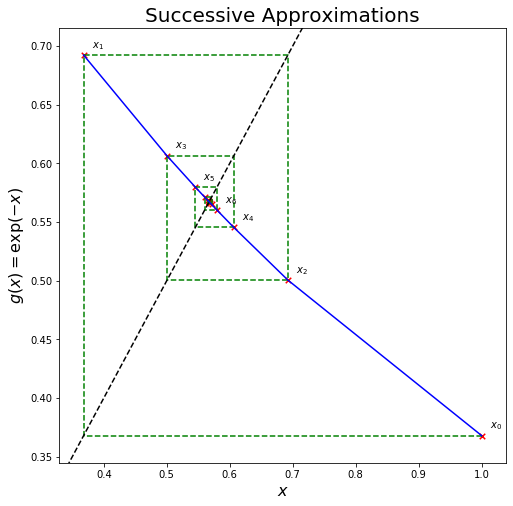

In [4]:
def plot_picard_convergence(f, x, ax, max_labels=6, atol=1.0e-4, flabel=''):
    """ Function to demonstrate/plot the Picard algorithm and its convergence
    """
    # variables to store solution iterations for plotting purposes
    xs = []
    fs = []

    # the following is identical to our iteration above, apart from storing iterations
    x_prev = x + 2*atol
    while abs(x - x_prev) > atol:
        x_prev = x
        x = f(x_prev)
        print('x_{0:0>2d} = {1:7.5f}.   g(x_{0:0>2d}) = {2:7.5f}.   |x_{0:0>2d} - g(x_{0:0>2d})| = {3:7.5f}'.
              format(len(xs), x_prev, x, abs(x_prev-x)))
        xs.append(x_prev)
        fs.append(x)  # as x = g(x_prev) at this point we can store this

    # plot the iteration results
    ax.scatter(xs, fs, marker='x', color='red', s=30)

    # plot the convergence pattern
    x_pattern = [xs[0]]
    f_pattern = [fs[0]]
    for i in range(1, len(xs)):
        x_pattern.append(xs[i])
        f_pattern.append(fs[i-1])
        x_pattern.append(xs[i])
        f_pattern.append(fs[i])
    ax.plot(x_pattern, f_pattern, 'g--')

    # plot the function over the x values considered
    idx_sort = np.argsort(xs)
    ax.plot(np.array(xs)[idx_sort], np.array(fs)[idx_sort], 'b')

    # add some labels
    # figure out a reasonable offset for labels
    dxt = (np.max(x_pattern)-np.min(x_pattern))/50.
    dyt = (np.max(f_pattern)-np.min(f_pattern))/50.
    ax.text(xs[0]+dxt, fs[0]+dyt, '$x_0$')
    # only plot a maximum of max_labels labels, so plot doesn't get too messy
    for i in range(1, min(max_labels+1, len(xs))):
        label = ''.join(['$x_{', str(i), '}$'])
        ax.text(xs[i]+dxt, fs[i]+dyt, label)

    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title('Successive Approximations', fontsize=20)


def g(x):
    return np.exp(-x)

# set up a figure for plotting
fig, ax1 = plt.subplots(figsize=(8, 8))
# set an initial guess - you can try different values for x_guess
x_guess = 1.0
# call our plotting function with above choice of function g(.), use the default stopping criterion
plot_picard_convergence(g, x_guess, ax1, flabel=r'$g(x) = \exp(-x)$')

# add a y=x line without extending the axes limits
ax1.autoscale(False)
xlim = plt.gca().get_xlim()
ax1.plot(xlim, xlim, 'k--')

This is an example of a so-called ["cobweb plot"](https://en.wikipedia.org/wiki/Cobweb_plot):

- We start from $x^{(0)}=1.0$ - shown as $x_0$ in the plot.


- We evaluate $g(x^{(0)}) = 0.36788...$. The red cross marked as $x_0$ is plotted at the location $(x^{(0)},g(x^{(0)}))$.


- We set our new iteration value, $x^{(1)}$, to this '$y$' value (i.e. $x^{(1)}:=g(x^{(0)})=0.36788...$) - the lowest green dashed horizontal  line takes us from $x^{(0)}$ to this new $x^{(1)}$ value - we jump horizontally to the $y=x$ line given by the black dashed line.


- We then evaluate $g(x^{(1)}) = 0.69220...$ - the left most vertical green dashed line takes us to this value on the $y$ axis where the second red cross marked with $x_1$ is plotted at the location $(x^{(1)},g(x^{(1)})$.


- We set our new $x$ value to this $(0.69220)$, and this is indicated by the top most horizontal green dashed line taking us back to the $y=x$ black dashed line.


- Evaluate $g$ of this value giving us 0.50047, this is our next vertical line


- and so on, converging to our fixed point

This plot shows that our algorithm *converges* to the point where $x = g(x)$, which in our case is $x = \mathrm{e}^{-x}$.

For this example this is the point where both $x$ and $g(x)$ equal ~0.57. 

It should be obvious that this method is iterative in nature and that the solution can be expected to be an approximation accurate to a tolerance of $e \leq$ `atol`. 

As we said at the start of this lecture, another way to visualise this is to plot the functions $y = x$ and $y = \mathrm{e}^{-x}$ in $(x,y)$ space and find the intersection.

Text(0.5, 1.0, 'Fixed point as the intersection of two curves')

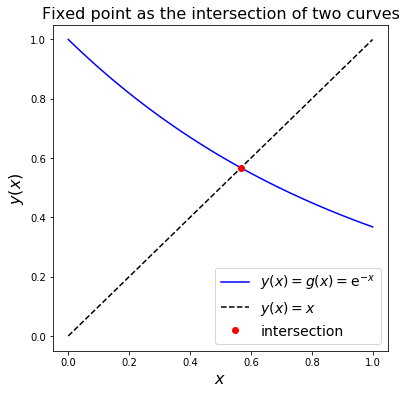

In [5]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)

x = np.linspace(0, 1, 100)

ax1.plot(x, np.exp(-x), 'b', label=r'$y(x) = g(x) = \mathrm{e}^{-x}$')
ax1.plot(x, x, 'k--', label='$y(x)=x$')
# our solution from Picard above: 0.5671430835570621
ax1.plot(0.5671430835570621, 0.5671430835570621, 'ro', label='intersection')
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y(x)$', fontsize=16)
ax1.set_title('Fixed point as the intersection of two curves', fontsize=16)

## Roots of equations

This graphical method shows the intersection point, $x = \mathrm{e}^{-x}$, also at ~0.57 (as of course is expected). 

This (fixed point) value is also termed a *root* of a closely related problem, as it satisfies 

$$ 0 = f(x) := x - \mathrm{e}^{-x}. $$

<br>

[So a "fixed point" can always be defined as a "root" of a related problem, but the opposite is not strictly speaking true. However, we will see below how it is possible via kind of a trick to update the problem of finding a "root" to finding a "fixed point", and hence reapply this sort of fixed point (e.g. Picard) iteration approach to this more general problem].

<br>

In this expression we rearranged $\,x = \mathrm{e}^{-x}\,$ to $\,0 = x - \mathrm{e}^{-x}\,$ and defined $\,f(x) := x - \mathrm{e}^{-x}$. 

Thus, another solution strategy is to find a value $x^*$ such that $f(x^*) = 0$, or, in our case, $x^* - \mathrm{e}^{-x^*} = 0$. 

<br>

We can of course plot a similar intersection figure for this modified problem.

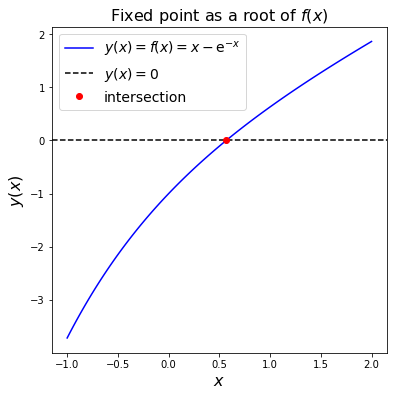

In [6]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)

x = np.linspace(-1, 2, 100)

ax1.plot(x, x-np.exp(-x), 'b', label='$y(x) = f(x) = x - \mathrm{e}^{-x}$')
# add a zero line extending across axes
xlim = ax1.get_xlim()
ax1.plot([xlim[0], xlim[1]], [0., 0.], 'k--', label='$y(x)=0$')
ax1.plot(0.5671, 0., 'ro', label='intersection')
ax1.set_xlim(xlim)
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y(x)$', fontsize=16)
ax1.set_title('Fixed point as a root of $f(x)$', fontsize=16);

# Subintervals and initial guesses
    
It is often the case that starting an iteration from a good initial guess for the value of the root (or fixed point) can be very important - how can we establish a good initial guess?

The graph above shows the root of $f(x)$ at our solution $x^* \approx 0.57$. By visual inspection, we see that $f(x)$ has a root $f(x^*) = 0$ in the interval $x^* \in (-1,1)$. 



## <span style="color:blue">Exercise 4.2:</span>


Let's consider an example:

$$2\,x + x \, \sin(x-3) = 5\;\;\;\; \text{for}\;\;\;\; x \in (-10,10).$$


By means of visual inspection (i.e. do some plotting) find a subinterval $(a,b)$ such that 


1. there exists an $x^* \in (a,b)$ such that $f(x^*) = 0$, and 


2. $f(x)$ is [monotonic](https://en.wikipedia.org/wiki/Monotonic_function) (i.e. is never increasing or never decreasing over the subinterval),


where we define $f$ such that the solution to the above equation is a root - i.e. move all the terms on to one side and set equal to zero. Below we make the choice to define $f$ as $f(x) := 2\,x + x \, \sin(x-3) - 5$.

In [ ]:
# for this problem we can define f as 5 - (2*x + x*np.sin(x-3)), or (2*x + x*np.sin(x-3)) - 5.
# it makes no difference to the root-finding, just the plots
def f(x):
    return ...

# plot the function over the whole interval being considered
x = np.linspace(-10,10,100)



# now plot the function over a smaller interval
x = np.linspace(0,5 , 100)




You should find that in $(0,5)$, i.e. an interval with upper and lower bounds $a$ = 0 and $b$ = 5, there exists a root, and also the function is monotonically increasing over this interval - we have excluded any local maxima or minima that we see to occur in the function outside this restricted interval.

[Note the caveat that in general we will assume the evaluation of $\,f$ (or $g$) is expensive and so we want to do this as few times as possible - generating a nice high resolution plot like this is not something we will be able to do in general].

We can make use of this knowledge to help us identify a good starting guess for the root.

# Root bracketing

Where the root lies can be important.

By visual inspection we can identify if roots exist for a function, and narrow down the interval in which a root can be found. 

For the equation 

$$f(x) := x - \text{e}^{-x},$$ 

we have shown by plotting (above in two images, see also below, where we noted a root around $x\approx ~0.57$) that a root is bounded in $(-1,1)$, and that $f(x)$ is monotonically increasing over this interval. 

With this in mind, we can define a [*root bracketing algorithm*](https://en.wikipedia.org/wiki/Root-finding_algorithm#Bracketing_methods) that marches along $f(x)$ in increments of $\Delta x$ and identifies a new, tighter (i.e. smaller) bracket around the root by detecting a *change in sign of $f(x)$*. 

This algorithm is also referred to as *incremental search*. 

The approach can be visualised as follows:

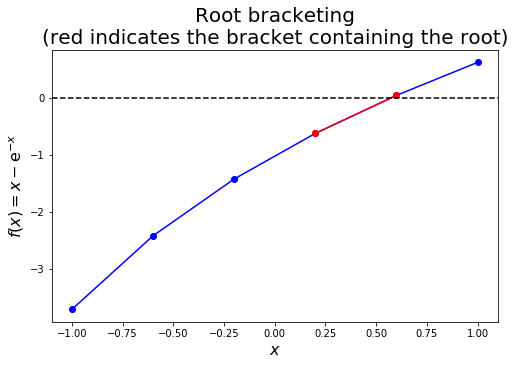

In [8]:
def plot_root_bracketing(f, a, b, dx, ax, xbounds=(-0.1, 1.4), ybounds=(-5, 6), flabel=''):
    x = np.linspace(a, b, int((b-a)/dx)+1)
    y = f(x)
    # plot the sub-intervals in blue
    ax.plot(x, y, 'bo-')
    for i in range(1, len(x)):
        if np.sign(y[i]) != np.sign(y[i-1]):
            # plot the sub-interval where the sign changes in red
            ax.plot([x[i], x[i-1]], [y[i], y[i-1]], 'ro-')
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], 'k--')
    ax.set_xlim(xlim)
    ax.set_title('Root bracketing\n' + '(red indicates the bracket containing the root)', fontsize=20)

    
def f(x):
    return x - np.exp(-x)


fig, ax1 = plt.subplots(figsize=(8,5))
    
lower_bound = -1.
upper_bound = 1.
dx = 0.4
plot_root_bracketing(f, lower_bound, upper_bound, dx, ax1, flabel=r'$f(x) = x - \mathrm{e}^{-x}$')

## <span style="color:blue">Exercise 4.3: </span>
    
For $2x + x \mathrm{sin}(x-3) = 5$, use the subinterval $x \in(a,b)$ you found in Exercise 4.2 and complete the code below to implement a function for the root bracketing algorithm. Derive the concept from the Figure above

In [ ]:
def f(x):
    return 2*x + x*np.sin(x-3) - 5


def root_bracketing(f, a, b, dx):
    """ Function to perform root bracketing on the function f(.)
    between a and b, with fixed interval size dx.
    Returns the bracket of size dx that contains the root.
    """ 
    # The sign function returns:  -1 if x < 0;  0 if x==0;  1 if x > 0.
    sign = np.sign(f(a))
    while ...
        .....
    return (a-dx, a)


a = 0.
b = 5.
dx = 0.1
# print out the output from our root_bracketing function
print('Bracket = ', root_bracketing(f, a, b, dx))

# Bisection method

Once we know that a root can be found in $x \in (a,b)$, we can close in on it with an algorithm similar to root-bracketing/incremental search described above, but with a smart switch to gradually *decrease* $\Delta x$ *by a factor* of 1/2, and *change the marching direction* depending on the sign of $f(x_1)f(x_2)$, where $x_1$ and $x_2$  are the local bounds considered during the marching process.


The algorithm works as follows:


- If there is a root in the interval $[x_1, x_2]$, then $f(x_1)f(x_2) < 0$ (as $f(x_1)$ and $f(x_2)$ will be of different signs)


- In order to halve the interval, we compute $f(x_3)$, where $x_3 := (x_1 + x_2)/2$ is the midpoint of the current interval. 


- If $f(x_2)f(x_3) < 0$, then the root must be in $[x_2, x_3]$, and we record this by replacing the original bound $x_1$ by $x_3$,


- otherwise, the root must lie in $[x_1, x_3]$, in which case $x_2$ is replaced by $x_3$. 


- In either case, the new updated interval $[x_1, x_2]$ is half the size of the original interval. 


- The bisection is repeated until the interval has been reduced to some user-defined convergence tolerance.


You can find <a href="https://en.wikipedia.org/wiki/Bisection_method#Algorithm">pseudo-code here</a>.


A visualisation of the method illustrates the narrowing in of an ever-smaller bracket:

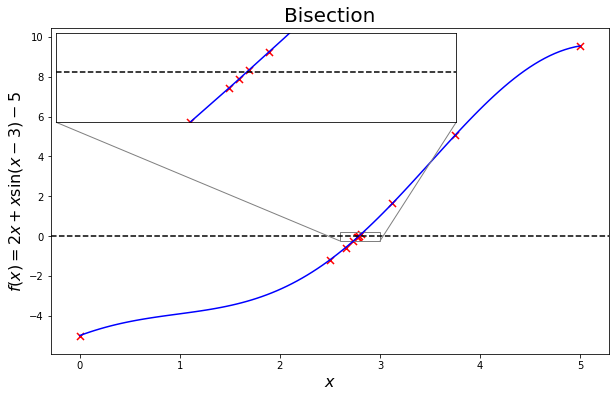

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_bisection(f, x1, x2, ax, tol=1.0e-2, inset=True, ixmin=0.4, ixmax=0.7, iymin=-0.25, iymax=0.2, zoom=5, loc0=4, loc1=2, loc2=1, flabel=''):
    # start by plotting the function over the given bounds (x1, x2)
    x = np.linspace(x1, x2, 100)
    y = f(x)
    ax.plot(x, y, 'b')
    # initialise the first interval
    f1 = f(x1)
    f2 = f(x2)
    x1s = x1
    x2s = x2
    # plot initial interval
    ax.scatter( [x1, x2], [f1, f2], marker='x', color='r', s=50)
    # plot midpoint, and update the appropriate interval limit
    while abs(x1-x2) > tol:
        x3 = 0.5*(x1 + x2)
        f3 = f(x3)
        ax.scatter( [x3], [f3], marker='x', color='r', s=50)
        if f2*f3 < 0.0:
            x1 = x3
            f1 = f3
        else:
            x2 = x3
            f2 = f3

    # add a zero line to the plot to help identify the root
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], color='k', ls='--')
    ax.set_xlim(xlim)
            
    # add a zoomed inset if 'inset=True'
    if inset:
        x1, x2 = x1s, x2s
        ax_ins = zoomed_inset_axes(ax, zoom, loc=loc0)
        # same code/algorithm as above
        x = np.linspace(x1, x2, 100)
        y = f(x)
        ax_ins.plot(x, y, color='b')
        f1 = f(x1)
        f2 = f(x2)
        ax_ins.scatter( [x1,x2], [f1,f2], marker='x', color='r', s=50)
        while abs(x1-x2) > tol:
            x3 = 0.5*(x1 + x2)
            f3 = f(x3)
            ax_ins.scatter( [x3], [f3], marker='x', color='r', s=50)
            if f2*f3 < 0.0:
                x1 = x3
                f1 = f3
            else:
                x2 = x3
                f2 = f3
        ax_ins.plot([ixmin,ixmax],[0.,0.], color='k',ls='--')
        ax_ins.set_xlim(ixmin, ixmax)
        ax_ins.set_ylim(iymin, iymax)
        ax_ins.get_xaxis().set_visible(False)
        ax_ins.get_yaxis().set_visible(False)
        # draw a box of area covered in main image and lines from corners to indicate zoom
        mark_inset(ax, ax_ins, loc1=loc1, loc2=loc2, fc='none', ec='0.5')
        
    xf = (x1 + x2)/2.0
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title('Bisection', fontsize=20)
    

# Let's see what it looks like for our example.

def f(x):
    return 2*x + x*np.sin(x-3) - 5


fig, ax1 = plt.subplots(figsize=(10,6))
plot_bisection(f, 0., 5., ax1, tol=1.0e-2, inset=True, 
               ixmin=2.6, ixmax=3., iymin=-0.25, iymax=0.2, zoom=10, loc0=2, loc1=3, loc2=4, flabel=r'$f(x) = 2x + x\sin(x-3) - 5$')

This algorithm has been <a href="http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.bisect.html#scipy.optimize.bisect">implemented</a> in the `scipy.optimize` module:

In [10]:
def f(x):
    return x - np.exp(-x)

a, b = -1., 1.
print(sop.bisect(f, a, b))

0.5671432904109679


## <span style="color:blue">Exercise 4.4: </span>

For $2x + x \mathrm{sin}(x-3) = 5$, use the subinterval $x \in(a,b)$ you found in Exercise 4.2 and complete the code below to implement a bisection algorithm. Derive the concept from a <a href="https://en.wikipedia.org/wiki/Bisection_method#Algorithm">pseudo-code description</a> and compare the result to `scipy.optimize.bisect`

In [ ]:
def bisection(fct, a, b, atol=1.0E-6, nmax=100):
    n = 0
    while n <= nmax:
        
        # complete
    
    raise RuntimeError('no root found within [a,b]')

def f(x):
    return # complete

a, b = # complete

print(bisection(f, a, b))
print(sop.bisect(f, a, b))

# Newton Method

So far, above iterative algorithms use only one part of a functions information: its value, $f(x)$. 

Newton's method additionally uses $f'(x)$ to infer the trend of the function in the vicinity of $x$. This slope, together with the function value $f(x)$, is used to find the intersection of the tangent at $x$ with zero to get an improved guess of the root. 

The formula can be derived from the [***Taylor series expansion:***](https://en.wikipedia.org/wiki/Taylor_series) (which we have already used in L2):

\begin{equation}
f(x_{i+1}) = f(x_i) + f'(x_i)(x_{i+1}-x_i) + \mathcal{O}(x_{i+1} - x_i)^2
\end{equation}

Let $f(x_{i+1}) = 0$ (as this is what we would like to occur, in practice we just need this to be sufficiently small for our algorithm and derivation to work) in order to obtain from the first terms in the Taylor series expansion:

\begin{equation}
0 = f(x_i) + f'(x_i)(x_{i+1}-x_i) + O(x_{i+1} - x_i)^2
\end{equation}

assuming $x_{i+1}$ is close to $x_{i}$ we can drop the higher order terms to find

\begin{equation}
x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}
\end{equation}

which is the so-called **Newton-Raphson formula**.

A pseudo pseudo-code for the algorithm looks like this:

```
guess x[0]
do
    x[i] = x[i-1] - f(x[i-1])/dfdx(x[i-1])
while abs(x[i] - x[i-1]) > tolerance
```

The expression of the associated error indicates quadratic convergence:

\begin{equation}
\epsilon_{i+1} = -\frac{f''(x)}{2f'(x)} \epsilon_{i}^2.
\end{equation}

For the case of $f(x) = x - \mathrm{e}^{-x}$, this approximation looks like the following.

Note that the green dashed lines extend off from the current iteration in the direction given by the slope of the blue line:

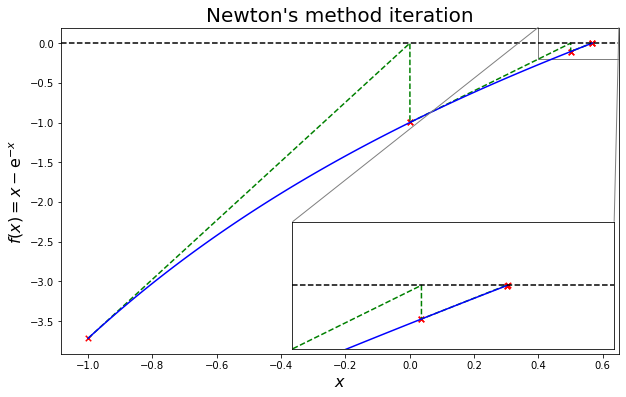

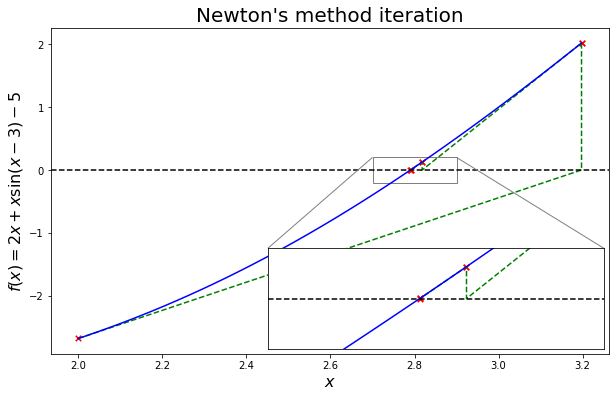

In [11]:
def plot_newton(f, dx, x_0, atol, ax, inset=True, ixmin=3.0, ixmax=3.2, 
                iymin=-0.1, iymax=0.1, zoom=8, loc0=1, loc1=3, loc2=2, maxiter=100, resfct=100, flabel=''):
    x_n = [x_0]
    y_n = [f(x_0)]    
    
    # Newton iteration
    i = 0
    # iterate until we hit break either as we hit tolerance or maximum number iterations
    while 1:
        # approximate gradient - computed using a dx value 
        # note comments below on quasi-newton!!
        dfdx = (f(x_n[-1]+dx) - f(x_n[-1])) / dx
        # Newton-Raphson update
        x_zero = x_n[-1] - ( f(x_n[-1]) / dfdx )
        x_n.append(x_zero)        
        y_n.append(0.)
        if abs(x_n[-1]-x_n[-2]) < atol:
            break
        x_n.append(x_zero)
        y_n.append(f(x_zero))
        i = i+1
        if i >= maxiter:
            break
        
    # the iteration results
    ax.scatter(x_n, f(np.array(x_n)), marker='x', color='red', s=30)
    
    # the convergence pattern
    ax.plot(x_n, y_n, color='green', ls='--')
        
    # the function
    x = np.linspace( np.min(x_n), np.max(x_n), resfct)
    ax.plot(x, f(x), 'b')
    
    # zero line
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], 'k--')
    ax.set_xlim(xlim)

    # zoomed inset
    if inset:
        axins = zoomed_inset_axes(ax, zoom, loc=loc0)
        axins.scatter(x_n, f(np.array(x_n)), marker='x', color='red', s=30)
        axins.plot(x_n, y_n, color='green', ls='--')
        axins.plot(x, f(x), 'b')
        axins.plot([ixmin,ixmax],[0.,0.], 'k--')
        axins.set_xlim(ixmin, ixmax)
        axins.set_ylim(iymin, iymax)
        axins.get_xaxis().set_visible(False)
        axins.get_yaxis().set_visible(False)
        mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.5")
    
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title("Newton's method iteration", fontsize=20)


# case 1
def f(x):
    return x - np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -1.
plot_newton(f, 1.e-3, x0, 1.e-2, ax1, loc0=4, loc1=2, loc2=1,
                                            zoom=4, ixmin=0.4, ixmax=0.65, iymin=-0.2, iymax=0.2,
                                            flabel=r'$f(x) = x - \mathrm{e}^{-x}$')

# case 2
def f(x):
    return 2*x + x*np.sin(x-3) - 5

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 2.0

plot_newton(f, 1.e-3, x0, 1.e-2, ax1, loc0=4, loc1=2, loc2=1,
                                            zoom=4, ixmin=2.7, ixmax=2.9, iymin=-0.2, iymax=0.2,
                                            flabel=r'$f(x) = 2x + x\sin(x-3) - 5$')

[Note that the above code actually plots the closely related quasi-Newton method, but that's good enough here to convey the points we want about how the Newton algorithm works].

This algorithm has been <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html">implemented</a> in the `scipy.optimize` module:

In [12]:
def f(x):
    return x - np.exp(-x)

def dfdx(x):
    return 1 + np.exp(-x)

x0 = -1. # initial guess
print(sop.newton(f, x0, dfdx))

0.567143290409784


## <span style="color:blue">Exercise 4.5: </span>

For $2x + x \mathrm{sin}(x-3) = 5$, use $a$ from the subinterval $x \in(a,b)$ you found in Exercise 4.2 as initial guess $x_0$ and complete the code below to implement a Newton algorithm. Compare the result to [scipy.optimize.newton](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html)

In [ ]:
def newton(f, x0, dfdx, atol=1.0e-6):
    """ Function to implement the Newton-Raphson method
    
    f is the function we are trying to find a root of
    
    and dfdx is another function which return the derivative of f
    """
    x = [x0]
    fevals = 0
    while True:
        x.append( ...............
        fevals +=  ...................
        if abs(x[-1]-x[-2]) < atol:
            print('Newton (analytical derivative) used', fevals, 'function evaluations')
            return x[-1]


def f(x):
    return # complete ...

def dfdx(x):
    return # complete ...

x0 = 0. # initial guess somwhere in interval
print(newton(f, x0, dfdx))
print(sop.newton(f, x0, dfdx))

## (Quasi-) Newton with approximate derivative 
    
The implementation of the Newton method above assumes that the derivative $f^\prime(x)$ is readily available. 

[Although note that this was not the case in the plotting function `plot_newton` where we computed an approximation to it].

For many problems, however, the derivative is not easy to express analytically or we just don't want to bother working it out and writing a function to implement it. 

In these cases $f^\prime(x)$ can be replaced by a difference approximation such we saw in L2:

$$ f'(x) \approx \frac{f(x+\Delta x) - f(x)}{\Delta x}. $$

Use of an approximate derivative renders the corresponding root finding algorithm a co-called *quasi-Newton* method.


Note that since we only have an approximate derivative we cannot in general expect this method to converge quite as well as Newton when we supply it with an exact derivative. This manifests in a reduction from perfect quadratic convergence - but still generally closer to quadratic that linear!

## <span style="color:blue">Exercise 4.6: </span>

Extend the Newton algorithm to compute $f^\prime(x)$ using a finite difference approximation. Compare the result to `scipy.optimize.newton`

In [ ]:
def quasi_newton(f, x0, dx=1.0E-7, atol=1.0E-6):
    """ Function to implement quasi-newton
    
    f is the function we are trying to find a root of
    """
    x = [x0]
    while True:
        ......
        ......
        if abs(x[-1]-x[-2]) < atol:
            return x[-1]

    
def f(x):
    return # complete ...

x0 = 0.
print(quasi_newton(f, x0))
print(sop.newton(f, x0))

# Secant Method

The Secant method replaces the local derivative in the Newton method by a difference approximation based on two consecutive $x_n$. It follows that

\begin{equation}
f'(x_n) \approx \frac{f(x_n) - f(x_{n-1})}{x_n - x_{n-1}}
\end{equation}

which leads to the secant method

\begin{equation}
x_{n+1} = x_n - f(x_n) \left ( \frac{x_n - x_{n-1}}{f(x_n) - f(x_{n-1})} \right )
\end{equation}

The algorithm can be visualized as follows:

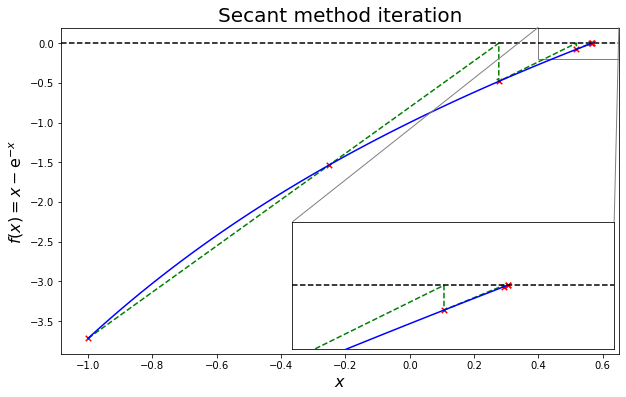

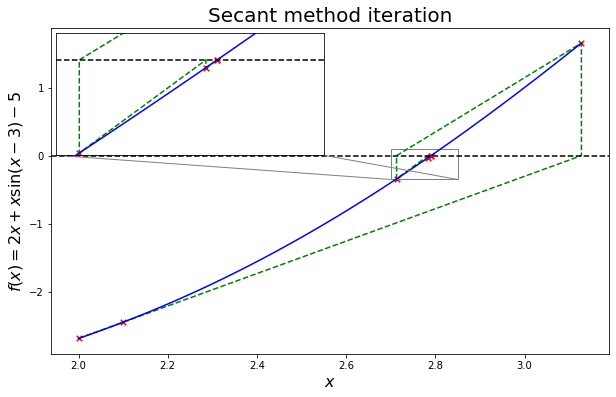

In [13]:
def plot_secant(f, x_0, x_1, atol, ax, max_labels0=1, inset=True, ixmin=3.0, ixmax=3.2, 
                iymin=-0.1, iymax=0.1, zoom=8, loc0=1, loc1=3, loc2=2, maxiter=100, resfct=100, flabel=''):
    # variables to store to convergence pattern, initialise with two initial guess values
    x_n = [x_0, x_1] 
    y_n = [f(x_0), f(x_1)]    
    x_its = [x_0, x_1]
    # iterate secant method and store iteration convergence pattern
    i = 0
    # iterate until we hit break either as we hit tolerance or maximum number iterations
    while 1:     
        # Secant update
        x_zero = x_its[-1] - f(x_its[-1])*( (x_its[-1] - x_its[-2]) / (f(x_its[-1]) - f(x_its[-2])) )
        x_n.append(x_zero)        
        y_n.append(0.)
        x_its.append(x_zero)
        if abs( x_n[-1] - x_n[-2] ) < atol:
            break
        x_n.append(x_zero)
        y_n.append(f(x_zero))
        i = i+1
        if i >= maxiter:
            break

    # the iteration results
    ax.scatter(x_its, f(np.array(x_its)), marker='x', color='red', s=30)
    
    # the convergence pattern
    ax.plot(x_n, y_n, color='green', ls='--')
     
    # the function
    x = np.linspace( np.min(x_n), np.max(x_n), resfct)
    ax.plot(x, f(x), 'b')

    # zero line
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], 'k--')
    ax.set_xlim(xlim)

    # zoomed inset
    if inset:
        axins = zoomed_inset_axes(ax, zoom, loc=loc0)
        axins.scatter(x_its, f(np.array(x_its)), marker='x', color='red', s=30)
        axins.plot(x_n, y_n, color='green', ls='--')
        axins.plot(x, f(x), 'b')
        axins.plot([ixmin,ixmax],[0.,0.], 'k--')
        axins.set_xlim(ixmin, ixmax)
        axins.set_ylim(iymin, iymax)
        axins.get_xaxis().set_visible(False)
        axins.get_yaxis().set_visible(False)
        mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.5")        
        
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title('Secant method iteration', fontsize=20)


# case 1
def f(x):
    return x - np.exp(-x)


x0 = -1.
x1 = x0+0.75
fig, ax1 = plt.subplots(figsize=(10,6))
plot_secant(f, x0, x1, 1E-3, ax1, loc0=4, loc1=2, loc2=1,
                                            zoom=4, ixmin=0.4, ixmax=0.65, iymin=-0.2, iymax=0.2,
                                            flabel=r'$f(x) = x - \mathrm{e}^{-x}$')

# case 2
def f(x):
    return 2*x + x*np.sin(x-3) - 5


fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 2.
x1 = x0+0.1
plot_secant(f, x0, x1, 1E-3, ax1, loc0=2, loc1=3, loc2=4, inset=True,
                                            zoom=4, ixmin=2.7, ixmax=2.85, iymin=-0.35, iymax=0.1,
                                            flabel=r'$f(x) = 2x + x\sin(x-3) - 5$')

## <span style="color:blue">Exercise 4.7:</span> 

For $2x + x \mathrm{sin}(x-3) = 5$, use $a$ from the subinterval $x \in(a,b)$ you found in Exercise 4.2 to find $x_0 = a$ and $x_1 = a+0.1$ and complete the code below to implement a Secant algorithm. Compare the result to `scipy.optimize.newton`

In [ ]:
def secant(f, x0, x1, atol=1.0E-6):
    """ Function to implement the secant method
    
    x0 and x1 are the two required guesses
    
    f is the function we are trying to find a root of
    """
    x = [x0, x1]
    while True:
        dfdx = .....
        x.append(.......
        if abs(x[-1]-x[-2]) < atol:
            return x[-1]

def f(x):
    return 2*x + x*np.sin(x-3) - 5

x0 = 0.
x1 = x0+0.1
print(secant(f, x0, x1))
print(sop.newton(f, x0))

# Potential convergence Issues

It's important to understand the ways some of the methods we've introduced can go wrong, and again to emphasise the value of a good starting guess.

Let's start by illustrating the basic concept of Newton root-finding methods for a well-behaved function

$$ f(x) := x^4 - 5. $$

Let's first reillustrate the basic concept of Newton root-finding methods for a well behaved function

\begin{equation}
f(x) = x^4 - 5
\end{equation}

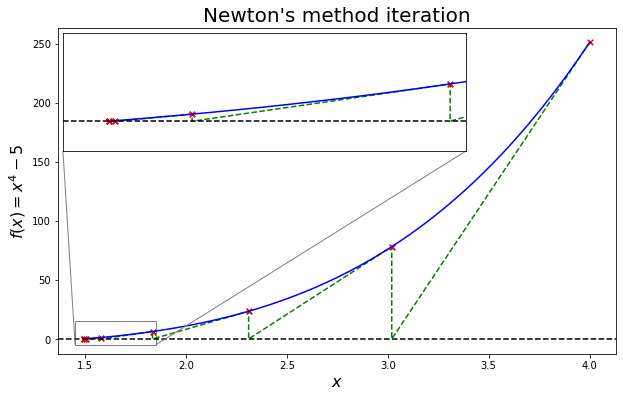

In [14]:
def f(x):
    return x**4 - 5

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 4.0
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, loc0=2, loc1=3, loc2=4, zoom=5,
                                            ixmin=1.45, ixmax=1.85, iymin=-5, iymax=15, flabel=r'$f(x) = x^4 - 5$')

We've said several times now that the convergence of many algorithms often depends on the initial values provided to them. 

Complex equations, or systems thereof, provide plenty of situations that prevent convergence all together, lead to slow convergence, or cause convergence to an undesired root (e.g. one that is far from, and not the closest to, the initial guess). 

Their solution strongly depends on having a *good* initial guess. 

For example,

$$ f(x) = x\, \sin(\pi x) - e^{-x}, $$

provides for ample pitfalls, in particular for gradient-based methods (e.g. Newton and Secant).

We will illustrate these convergence issues below. 


They mostly fall into one of three categories:


1. Multiple roots in the vicinity - the algorithm converges to one of them, but this "one" could change with only slight changes to the initial guess.


2. Nearly singular/numerical overflow - the local gradient at guess $x^{(k)}$ is near zero, so that $x^{(k+1)}$, the intersection of the local gradient approximation with the $x$ axis is beyond the representable range. Even if we don't get overflow, we can still jump to a location a long distance away from our initial guess and end up converging to the wrong root.


3. Oscillations - the algorithm bounces back and forth between (near) identical $x^{(k)}$.

## Multiple roots

For many functions multiple roots exist, and the algorithm depends on and can be sensitive to the initial guess.

Let's see an example where we choose two initial guesses (0.0 and 0.1) and visualise how this relatively small difference leads to convergence to different roots.

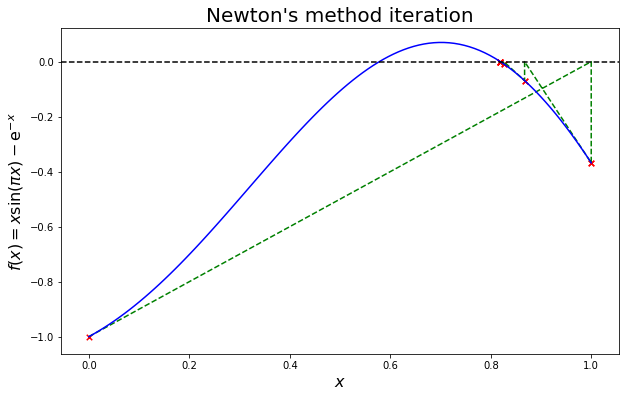

In [15]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 0.0
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

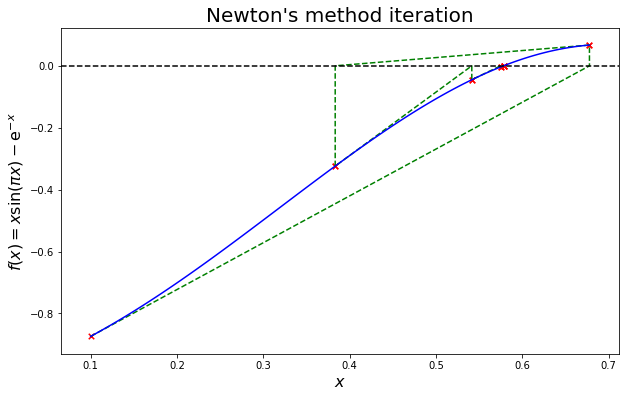

In [16]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
# a small perturbation to the initial guess
x0 = 0.1
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

We see from the first plot that this problem has roots at just under 0.6 and just over 0.8.  The initial guess of 0 leads to convergence of the Newton iteration to the larger root, whereas a slightly higher initial guess of 0.1 leads to the smaller root!

We confirm this behaviour is not a product of an issue with our implementation, and print the two actual root values, using calls to the SciPy function below.

In [17]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

x0 = 0.0
print(sop.newton(f, x0))
x0 = 0.1
print(sop.newton(f, x0))

0.8191177934425945
0.578262577864515


## Nearly singular/numerical overflow

In this case the gradient $\,f'(x^{(k)})\,$ is close to zero, so that the new iteration value, $x^{(k+1)}$, is orders of magnitude offset, perhaps too big even to be representable on our finite computer ([*overflow*](https://en.wikipedia.org/wiki/Integer_overflow)).

We see this with the following example.

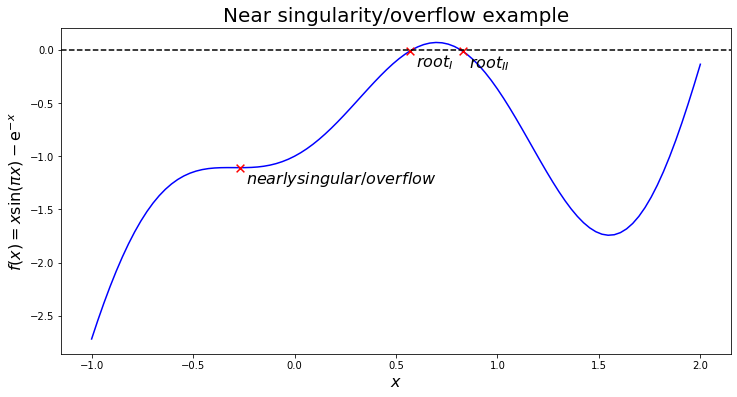

In [18]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

x = np.linspace(-1, 2, 100)
y = f(x)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(x, y, color='b', zorder=0)
xs = [0.57, 0.83, -0.27]
texts = ['$root_I$', '$root_{II}$', '$nearly singular/overflow$']
for i in range(len(xs)):
    ax1.scatter([xs[i]], [f(xs[i])], marker='x', color='r', s=60)
    ax1.text(xs[i]+0.03, f(xs[i])-0.15, texts[i], fontsize=16)
xlim = ax1.get_xlim()
ax1.plot([xlim[0], xlim[1]], [0., 0.], 'k--', label='$y(x)=0$')
ax1.set_xlim(xlim)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$', fontsize=16)
ax1.set_title('Near singularity/overflow example', fontsize=20);

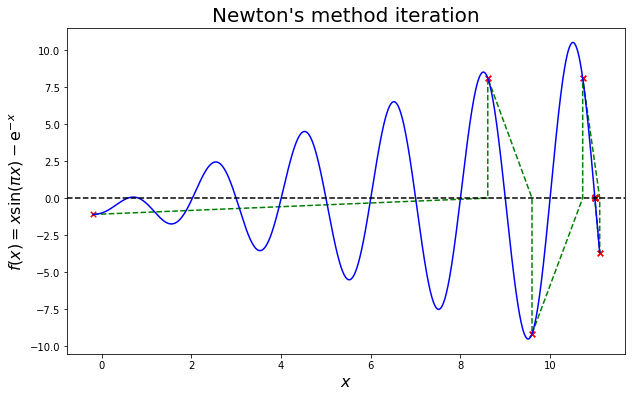

In [19]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.2
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

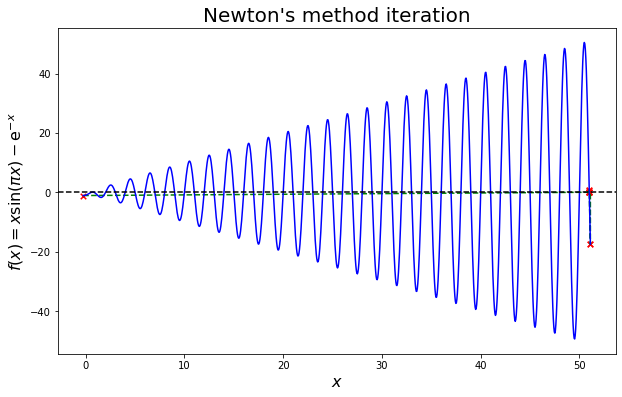

In [20]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.25
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

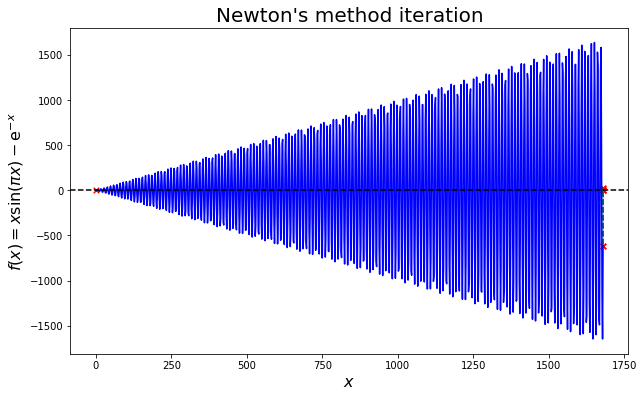

In [21]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.268
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

C:\Users\mdpig\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\mdpig\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


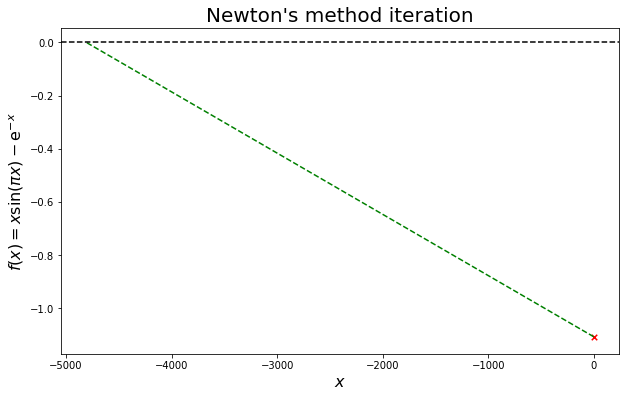

In [22]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.269
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

In [23]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

# do we converge for a slightly larger initial guess?
x0 = -0.2684
print(sop.newton(f, x0))

# but see what happens if you make this x0 very slightly smaller!
x0 = -0.2685
print(sop.newton(f, x0))



# we converge to the first root in the image above if we start with an appropriate value
x0 = 0.5
print(sop.newton(f, x0))


# and similarly the second root shown in the above plot
x0 = 1.0
print(sop.newton(f, x0))

4.999570827870424
24017.65375762087
0.578262577864515
0.8191177934426116


C:\Users\mdpig\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


## Oscillation

In this scenario the iterations are trapped in a region with gradients of approximately equal magnitude but opposite directions.

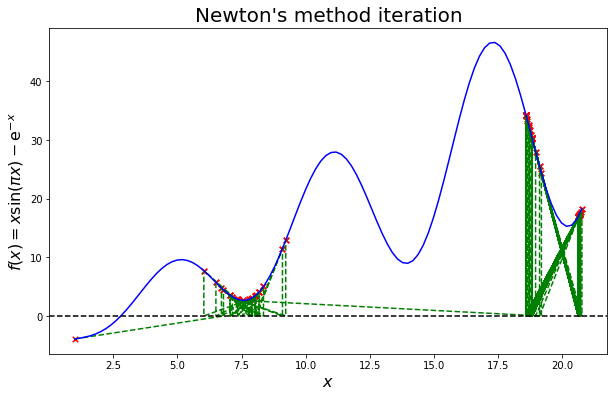

In [51]:
def f(x):
    return 2*x + x*np.sin(x-3) - 5

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 1.
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=104, 
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

What happens if you increase the number of iterations?

Another similar example:

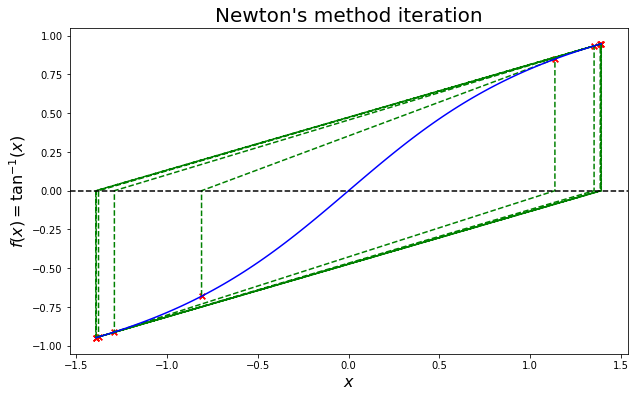

In [25]:
def f(x):
    return np.arctan(x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -1.3917
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=10, 
                                            flabel='$f(x)= \mathrm{tan}^{-1}(x)$')